In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import pmdarima as pm
import arch

In [9]:
DATA_PATH = os.path.join(os.path.abspath('../../'), 'db', 'data')
PRIMARY_PATH = os.path.join(DATA_PATH, 'primary')
SECONDARY_PATH = os.path.join(DATA_PATH, 'secondary')
TERTIARY_PATH = os.path.join(DATA_PATH, 'tertiary')

wpath = os.path.join(DATA_PATH, 'merge')

# GOAL: Garch + ARIMA combined (often best practice)
![Red: ARMA, Green: Garch](https://miro.medium.com/max/862/1*azEK9WckHXBx73L8bTPu6Q.png) Red: ARMA, Green: Garch

In [108]:
#Curency indexes dataframe for EUR currency and limited nr of rows
df = pd.read_csv(os.path.join(wpath, os.path.basename(TERTIARY_PATH), 'idxs_.csv'), parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
# df = df[['EUR']]
# df.loc[ df['EUR'] ] = df.fillna()

In [111]:
df.describe()

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
count,6334.000000,6334.000000,6334.000000,6334.000000,6334.000000,6334.000000,6334.000000,6334.000000
mean,-437.457917,-646.131054,326.642299,593.782613,200.932968,760.631946,-164.702894,166.302038
std,307.365249,433.705399,130.841664,285.063023,58.269077,381.385927,152.814225,38.276478
min,-959.467097,-1407.305606,100.071552,100.155890,100.031865,100.208566,-429.322220,100.020932
25%,-706.054455,-1019.126382,213.356926,346.969252,150.482417,430.420256,-297.012557,133.161485
50%,-441.573863,-642.015107,326.642299,593.782613,200.932968,760.631946,-164.702894,166.302038
75%,-170.360200,-271.636904,439.927672,840.595974,251.383520,1090.843637,-32.393231,199.442591
max,99.835644,99.759119,553.213045,1087.409336,301.834071,1421.055327,99.916432,232.583144


In [47]:
# df.loc[ df['EUR']==- float('inf') ] = 0

EUR    20
dtype: int64

Text(0.5, 1.0, '1st Order Differencing')

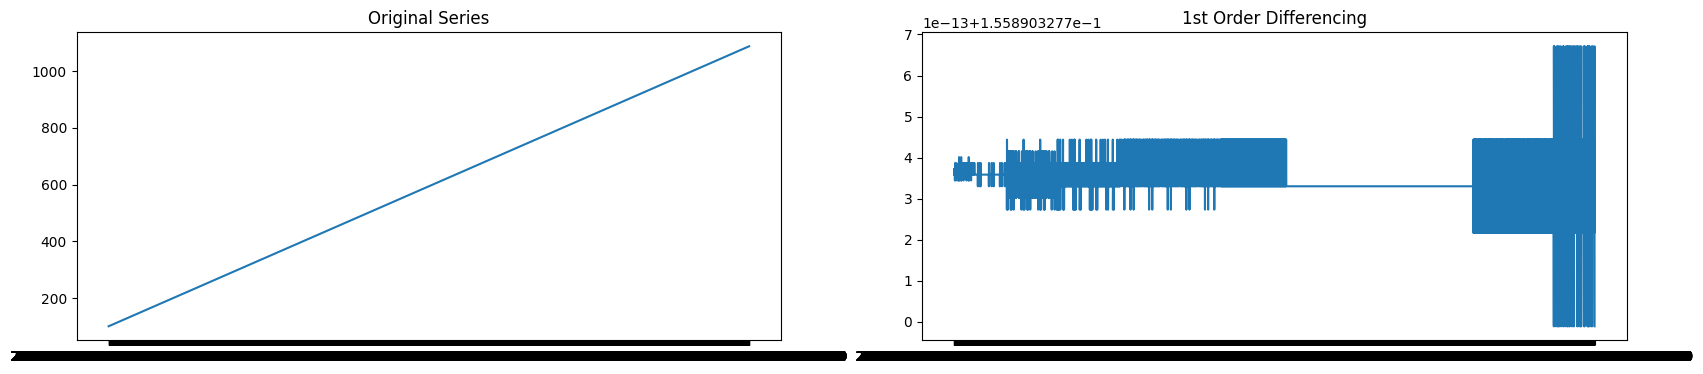

In [82]:
zero_diff = df.EUR
first_order_diff = df.EUR.diff(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')

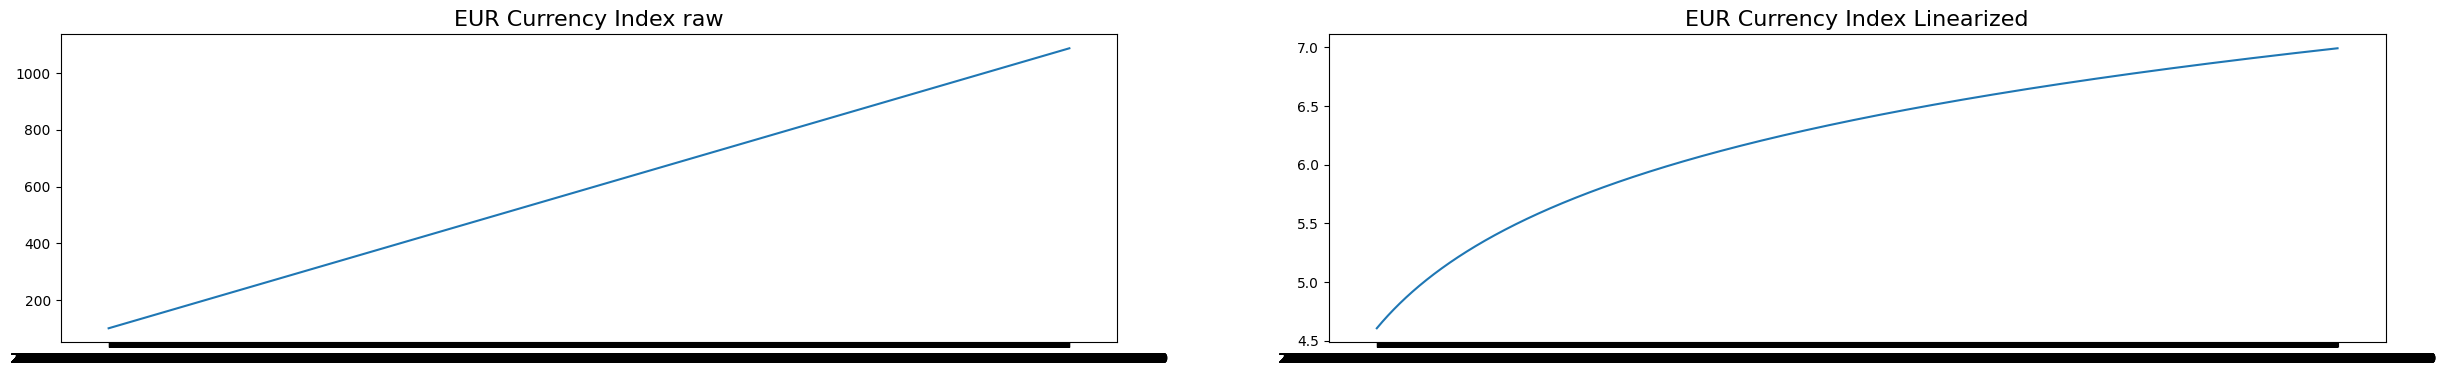

In [83]:
# Remove exponential trend for EUR
plt.figure(figsize=(30,4));

plt.subplot(1,2,1); plt.plot(df.EUR);
plt.title('EUR Currency Index raw', fontsize=16);

df['EUR_linear'] = np.log(df.EUR)

plt.subplot(1,2,2); plt.plot(df['EUR_linear']);
plt.title('EUR Currency Index Linearized', fontsize=16);

# check correlation plots

In [87]:
from statsmodels.tsa.stattools import adfuller

adfuller(df.EUR_linear)[1]  # p-value

0.9585282171568785

In [88]:
df.describe()

,EUR,EUR_linear
count,6334.000000,6334.000000
mean,593.782613,6.233423
std,285.063023,0.603937
min,100.155890,4.606728
25%,346.969252,5.849236
50%,593.782613,6.386513
75%,840.595974,6.734111
max,1087.409336,6.991553


In [89]:
# First prepare the diff EUR data
y_diff = df['EUR_linear'].diff().dropna()

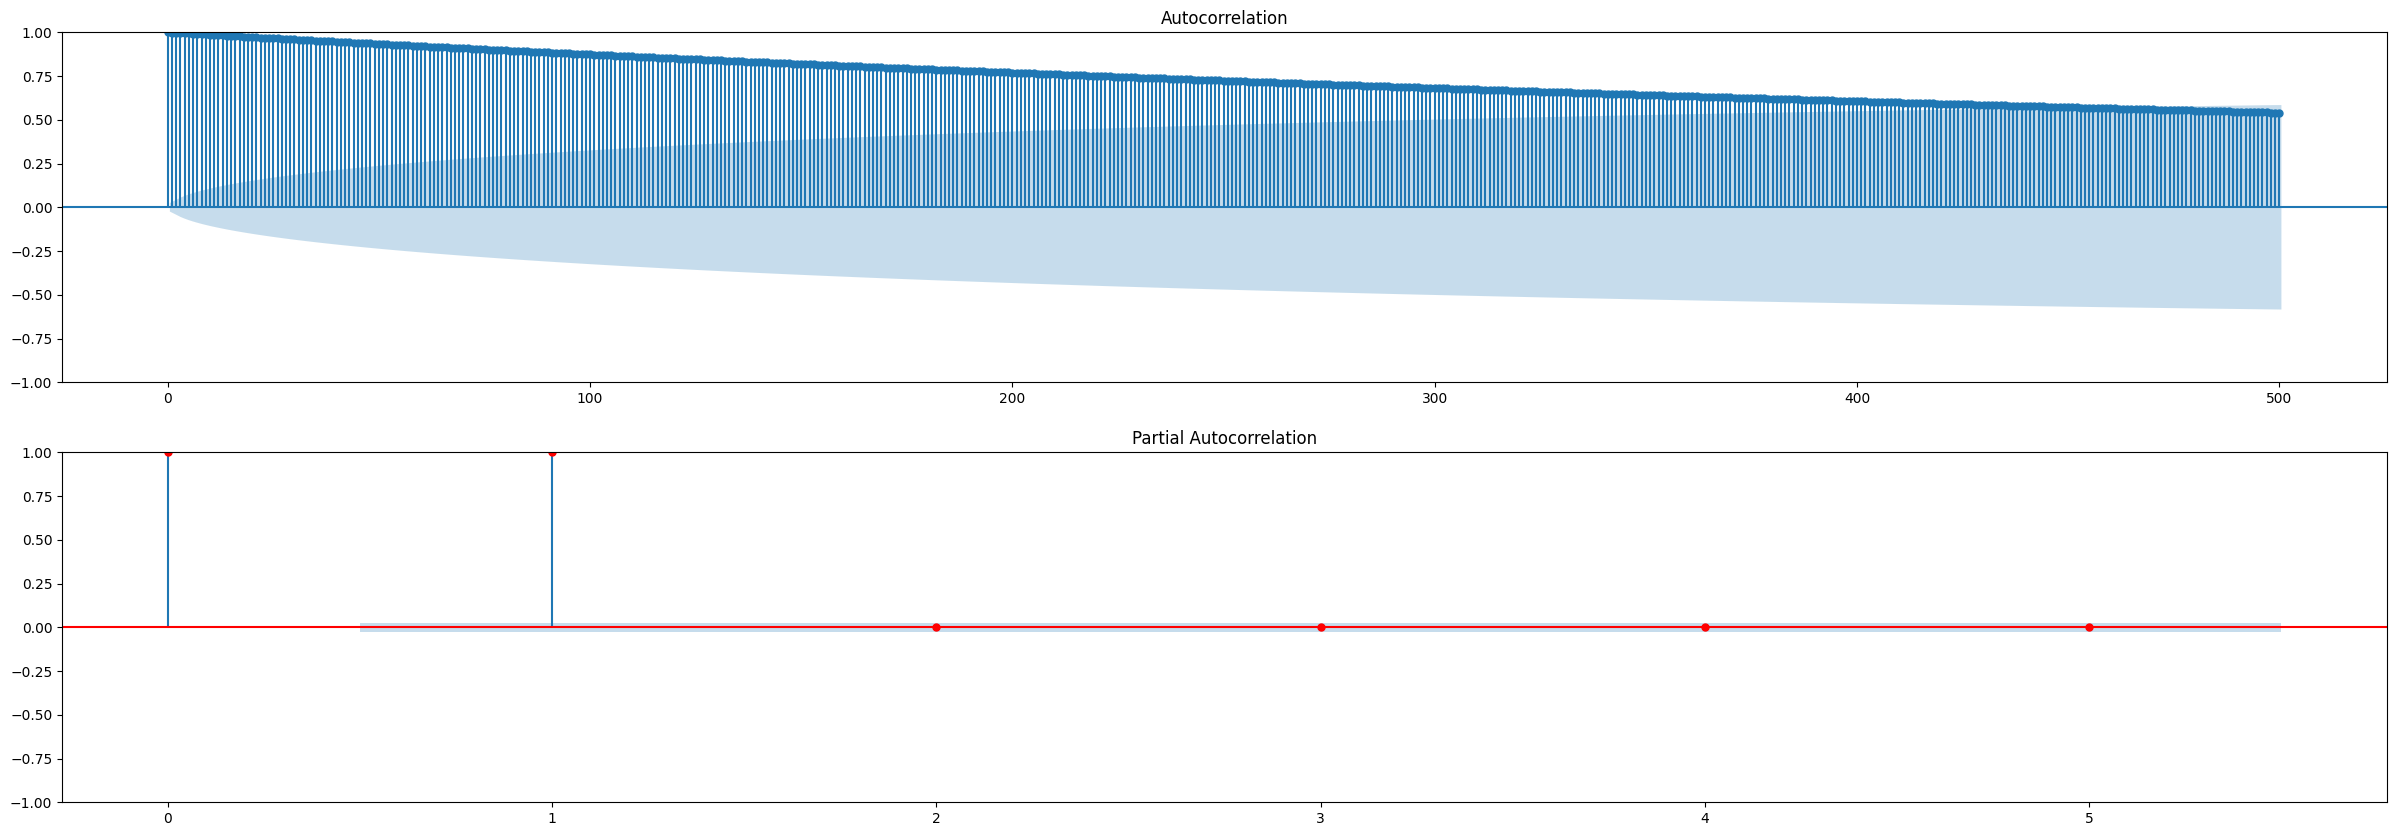

In [98]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(2,1, figsize=(30,10))
plot_acf(y_diff, lags=500, ax=axes[0]);
plot_pacf(y_diff, lags=5, ax=axes[1], c='r');

In [102]:
model = pm.auto_arima(df.EUR,
                       start_p=1, max_p=500,
                       start_q=0, max_q=2,
                       seasonal=False,
                       trend='t',
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-134155.405, Time=1.31 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-134157.405, Time=0.96 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-134155.405, Time=1.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-134157.405, Time=0.90 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-134153.405, Time=1.68 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 6.121 seconds


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [78]:
# best params
print(model.order)
print('---===---')
arima_residuals = model.arima_res_.resid
# Use ARIMA to predict mu
predicted_mu = model.predict(n_periods=1)[0]
predicted_mu
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1, reindex=True)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et
print(f'\n \n Predicted value: is \n {prediction}')

(1, 1, 0)
---===---
Iteration:      1,   Func. Count:      6,   Neg. LLF: 548.1954245466595
Iteration:      2,   Func. Count:     12,   Neg. LLF: 66.89867000435778
Iteration:      3,   Func. Count:     17,   Neg. LLF: 64.19895890025686
Iteration:      4,   Func. Count:     22,   Neg. LLF: 63.159155469837756
Iteration:      5,   Func. Count:     27,   Neg. LLF: 155.18853585487196
Iteration:      6,   Func. Count:     33,   Neg. LLF: 450.2456335617902
Iteration:      7,   Func. Count:     39,   Neg. LLF: 602.8026234853455
Iteration:      8,   Func. Count:     45,   Neg. LLF: 48.323112716583964
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1168565.4584505951
Iteration:     10,   Func. Count:     61,   Neg. LLF: 6318830.455889741
Iteration:     11,   Func. Count:     67,   Neg. LLF: 2317.6302090838785
Iteration:     12,   Func. Count:     73,   Neg. LLF: 150.79029081988816
Iteration:     13,   Func. Count:     79,   Neg. LLF: 61.44698478452727
Iteration:     14,   Func. Count:     

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Define your input data
data = pd.read_csv(os.path.join(wpath, os.path.basename(TERTIARY_PATH), 'idxs_.csv'), parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
data.index = pd.to_datetime(data.index)

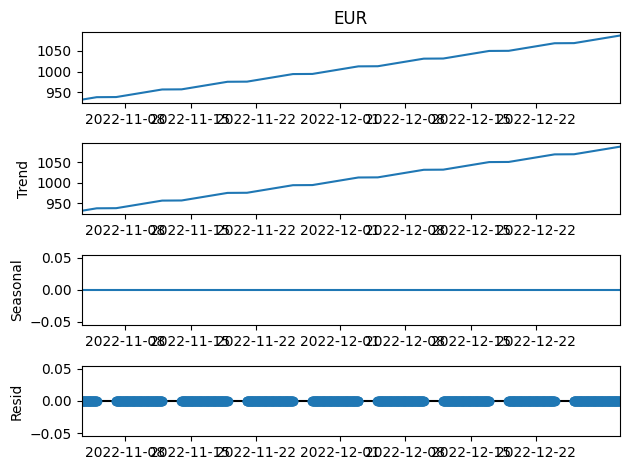

In [17]:
result_add = seasonal_decompose(data.EUR[-1000:], period=1, model='additive')
result_add.plot();
# result_mul = seasonal_decompose(df['EUR'], model='multiplicative')

In [19]:
%%time

def getSeasonality(data, rows=10, period=1):
    '''
    Check seasonality of the given data
    '''
    %%time
    for column in data.columns:
        result_add = seasonal_decompose(data[column][-rows], period = period, model='additive', extrapolate_trend='freq')
        result_mul = seasonal_decompose(data[column][-rows], period = period, model='multiplicative', extrapolate_trend='None')
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,6))
        ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
        ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals")
        plots = []
        plots.append(plt.show())
    return plots

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [ ]:
def getAdfTest(data):
    
    for column in data.columns:
        print(f'Adfuller Coef: {adfuller(data.column)[0]}')
        print('additive resid: ', adfuller(result_add.resid.dropna())[1])
        print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])
        print(f'\n ------------- \n')
    pass        
        

In [ ]:
# Address seasonality, trend
for column in data.columns:
    df.column = 
    data_deseason.iloc[column]

In [ ]:

for column in data.columns:
    data_deseason.iloc[]

    arima_residuals_s = smodel.arima_res_.resid
    # Use ARIMA to predict mu
    predicted_mu_s = smodel.predict(n_periods=1)[0]
    predicted_mu_s

    # fit a GARCH(1,1) model on the residuals of the ARIMA model
    garch_s = arch.arch_model(arima_residuals, p=1, q=1)
    garch_fitted_s = garch_s.fit()

    # Use GARCH to predict the residual
    garch_forecast_s = garch_fitted_s.forecast(horizon=1, reindex=True)
    predicted_et_s = garch_forecast_s.mean['h.1'].iloc[-1]

    # Combine both models' output: yt = mu + et
    prediction_s = predicted_mu_s + predicted_et_s
    print(f'\n Predicted value: is \n {prediction_s}')

In [98]:
# crete differentiated test data
test = df[['EUR']][2000:3000]
# test.dropna()